# Resampling Methods

## Left out samples validation

The **training error** can be easily calculated by applying the statistical learning method to the observations used in its training. But because of overfitting, the training error rate can dramatically underestimate the error that would be obtained on new samples.


The **test error** is the average error that results from a learning method to predict the response on a new samples that is, on samples that were not used in training the method. Given a data set, the use of a particular learning method is warranted if it results in a low test error. The test error can be easily calculated if a designated test set is available. Unfortunately, this is usually not the case.

Thus the original dataset is generally splited in a training and a test (or validation) data sets. Large training set (80%) small test set (20%) might provide a poor estimation of the predictive performances. On the contrary, large test set and small training set might produce a poorly estimated learner. This is why, on situation where we cannot afford such split, it recommended to use cross-Validation scheme to estimate the predictive power of a learning algorithm.


## Cross-Validation (CV)

Cross-Validation scheme randomly divid the set of observations into $K$ groups, or **folds**, of approximately equal size. The first fold is treated as a validation set, and the method $f()$ is fitted on the remaining union of $K - 1$ folds: ($f(X_{-K}, y_{-K})$).

The mean error measure (generally a loss function) is evaluated of the on the observations in the held-out fold. For each sample $i$ we consider the model estimated on the data set that did not contain it, noted $-K(i)$. This procedure is repeated $K$ times; each time, a different group of observations is treated as a test set.
Then we compare the predicted value ($f(X_{-K(i)}) = \hat{y_i})$ with true value $y_i$ using a Error function $L()$. Then the cross validation estimate of prediction error is

$$
CV(f) = \frac{1}{N} \sum_i^N L\left(y_i, f(X_{-K(i)}) \right).
$$

This validation scheme is known as the **K-Fold CV**. Typical choices of $K$ are 5 or 10, [Kohavi 1995]. The extreme case where $K = N$ is known as **leave-one-out cross-validation, LOO-CV**.

### CV for regression

Usually the error function $L()$ is the r-squared score. However other function could be used.

In [18]:
import numpy as np
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.cross_validation import KFold

X, y = datasets.make_regression(n_samples=100, n_features=100, 
                         n_informative=10, random_state=42)
model = lm.Ridge(alpha=10)

cv = KFold(len(y), n_folds=5, random_state=42)
y_test_pred = np.zeros(len(y))
y_train_pred = np.zeros(len(y))

for train, test in cv:
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    model.fit(X_train, y_train)
    y_test_pred[test] = model.predict(X_test)
    y_train_pred[train] = model.predict(X_train)

print("Train r2:%.2f" % metrics.r2_score(y, y_train_pred))
print("Test  r2:%.2f" % metrics.r2_score(y, y_test_pred))

Train r2:0.99
Test  r2:0.72


Scikit-learn provides user-friendly function to perform CV:

In [19]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test  r2:%.2f" % scores.mean())

# provide a cv
scores = cross_val_score(estimator=model, X=X, y=y, cv=cv)
print("Test  r2:%.2f" % scores.mean())

Test  r2:0.73
Test  r2:0.73


### CV for classification

With classification problems it is essential to sample folds where each set contains approximately the same percentage of samples of each target class as the complete set. This is called **stratification**. In this case, we will use ``StratifiedKFold`` with is a variation of k-fold which returns stratified folds.

Usually the error function $L()$ are, at least, the sensitivity and the specificity. However other function could be used.

In [20]:
import numpy as np
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.cross_validation import StratifiedKFold

X, y = datasets.make_classification(n_samples=100, n_features=100, 
                         n_informative=10, random_state=42)

model = lm.LogisticRegression(C=1)

cv = StratifiedKFold(y, n_folds=5)
y_test_pred = np.zeros(len(y))
y_train_pred = np.zeros(len(y))

for train, test in cv:
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    model.fit(X_train, y_train)
    y_test_pred[test] = model.predict(X_test)
    y_train_pred[train] = model.predict(X_train)

recall_test  = metrics.recall_score(y, y_test_pred, average=None)
recall_train = metrics.recall_score(y, y_train_pred, average=None)
acc_test = metrics.accuracy_score(y, y_test_pred)


print("Train SPC:%.2f; SEN:%.2f" % tuple(recall_train))
print("Test  SPC:%.2f; SEN:%.2f" % tuple(recall_test))
print("Test  ACC:%.2f" % acc_test)

Train SPC:1.00; SEN:1.00
Test  SPC:0.80; SEN:0.82
Test  ACC:0.81


Scikit-learn provides user-friendly function to perform CV:

In [21]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
scores.mean()

# provide CV and score
def balanced_acc(estimator, X, y):
    '''
    Balanced acuracy scorer
    '''
    return metrics.recall_score(y, estimator.predict(X), average=None).mean()

scores = cross_val_score(estimator=model, X=X, y=y, cv=cv, scoring=balanced_acc)
print("Test  ACC:%.2f" % scores.mean())

Test  ACC:0.81


Note that with Scikit-learn user-friendly function we average the scores' average obtained on individual folds which may provide slightly different results that the overall average presented earlier.

## CV for model selection: setting the hyper parameters

It is important to note CV may be used for two separate goals:

1. **Model assessment**: having chosen a final model, estimating its prediction error (generalization error) on new data.

2. **Model selection**: estimating the performance of different models in order to choose the best one. One special case of model selection is the selection model's hyper parameters. Indeed remember that most of learning algorithm have a hyper parameters (typically the regularization parameter) that has to be set.

Generally we must address the two problems simultaneously. The usual approach for both problems is to randomly divide the dataset into three parts: a training set, a validation set, and a test set.

- The **training set** (train) is used to fit the models;

- the **validation set** (val) is used to estimate prediction error for model selection or to determine the hyper parameters over a grid of possible values.

- the **test set** (test) is used for assessment of the generalization error of the final chosen model.


### Grid search procedure

Model selection of the best hyper parameters over a grid of possible values

For each possible values of hyper parameters $\alpha_k$:

1. Fit the learner on training set: $f(X_{train}, y_{train}, \alpha_k)$

2. Evaluate the model on the validation set and keep the parameter(s) that minimises the error measure

    $\alpha_* = \arg \min L(f(X_{train}), y_{val}, \alpha_k)$

3. Refit the learner on all training + validation data using the best hyper parameters: $f^* \equiv f(X_{train \cup val}, y_{train \cup val}, \alpha_*)$

4. ** Model assessment ** of $f^*$ on the test set: $L(f^*(X_{test}), y_{test})$

### Nested CV for model selection and assessment

Most of time, we cannot afford such three-way split. Thus, again we will use CV, but in this case we need two nested CVs.

One **outer CV loop, for model assessment**. This CV performs $K$ splits of the dataset into training plus validation ($X_{-K}, y_{-K}$) set and a test set $X_{K}, y_{K}$

One **inner CV loop, for model selection**. For each run of the outer loop, the inner loop loop performs $L$ splits of dataset ($X_{-K}, y_{-K}$) into training set: ($X_{-K,-L}, y_{-K,-L}$) and a validation set: ($X_{-K,L}, y_{-K,L}$).

### Implementation with scikit-learn

Note that the inner CV loop combined with the learner form a new learner with an automatic model (parameter) selection procedure. This new learner can be easily constructed using Scikit-learn. The learned is wrapped inside a ``GridSearchCV`` class.

Then the new learned can be pluged into the classical outer CV loop.

In [22]:
import numpy as np
from sklearn import datasets
import sklearn.linear_model as lm
from sklearn.grid_search import GridSearchCV
import sklearn.metrics as metrics
from sklearn.cross_validation import KFold

# Dataset
noise_sd = 10
X, y, coef = datasets.make_regression(n_samples=50, n_features=100, noise=noise_sd,
                         n_informative=2, random_state=42, coef=True)
 
# Use this to tune the noise parameter such that snr < 5
print("SNR:", np.std(np.dot(X, coef)) / noise_sd)

# param grid over alpha & l1_ratio
param_grid = {'alpha': 10. ** np.arange(-3, 3), 'l1_ratio':[.1, .5, .9]}


# Warp 
model = GridSearchCV(lm.ElasticNet(max_iter=10000), param_grid, cv=5)
    
# 1) Biased usage: fit on all data, ommit outer CV loop                 
model.fit(X, y)
print("Train r2:%.2f" % metrics.r2_score(y, model.predict(X)))
print(model.best_params_)

# 2) User made outer CV, usefull to extract specific imformation 
cv = KFold(len(y), n_folds=5, random_state=42)
y_test_pred = np.zeros(len(y))
y_train_pred = np.zeros(len(y))
alphas = list()

for train, test in cv:
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    model.fit(X_train, y_train)
    y_test_pred[test] = model.predict(X_test)
    y_train_pred[train] = model.predict(X_train)
    alphas.append(model.best_params_)

print("Train r2:%.2f" % metrics.r2_score(y, y_train_pred))
print("Test  r2:%.2f" % metrics.r2_score(y, y_test_pred))
print("Selected alphas:", alphas)

# 3.) user-friendly sklearn for outer CV
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=model, X=X, y=y, cv=cv)
print("Test  r2:%.2f" % scores.mean())

SNR: 2.63584694464
Train r2:0.96
{'l1_ratio': 0.9, 'alpha': 1.0}
Train r2:1.00
Test  r2:0.62
Selected alphas: [{'l1_ratio': 0.9, 'alpha': 0.001}, {'l1_ratio': 0.9, 'alpha': 0.001}, {'l1_ratio': 0.9, 'alpha': 0.001}, {'l1_ratio': 0.9, 'alpha': 0.01}, {'l1_ratio': 0.9, 'alpha': 0.001}]
Test  r2:0.55


### Regression models with built-in cross-validation

Sklearn wil automaticaly select a grib of parameters, most of time use the defaults values.

``n_jobs`` is the number of CPUs to use during the cross validation. If -1, use all the CPUs.


In [23]:
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.cross_validation import cross_val_score

# Dataset
X, y, coef = datasets.make_regression(n_samples=50, n_features=100, noise=10,
                         n_informative=2, random_state=42, coef=True)
 

print("== Ridge (L2 penalty) ==")
model = lm.RidgeCV()
# Let sklearn select a list of alphas with default LOO-CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test  r2:%.2f" % scores.mean())

print("== Lasso (L1 penalty) ==")
model = lm.LassoCV(n_jobs=-1)
# Let sklearn select a list of alphas with default 3CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test  r2:%.2f" % scores.mean())

print("== ElasticNet (L1 penalty) ==")
model = lm.ElasticNetCV(l1_ratio=[.1, .5, .9], n_jobs=-1)
# Let sklearn select a list of alphas with default 3CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test  r2:%.2f" % scores.mean())

== Ridge (L2 penalty) ==
Test  r2:0.23
== Lasso (L1 penalty) ==
Test  r2:0.74
== ElasticNet (L1 penalty) ==
Test  r2:0.58


### Classification models with built-in cross-validation

In [24]:
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.cross_validation import cross_val_score

X, y = datasets.make_classification(n_samples=100, n_features=100, 
                         n_informative=10, random_state=42)

# provide CV and score
def balanced_acc(estimator, X, y):
    '''
    Balanced acuracy scorer
    '''
    return metrics.recall_score(y, estimator.predict(X), average=None).mean()

print("== Logistic Ridge (L2 penalty) ==")
model = lm.LogisticRegressionCV(class_weight='balanced', scoring=balanced_acc, n_jobs=-1)
# Let sklearn select a list of alphas with default LOO-CV
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)
print("Test  ACC:%.2f" % scores.mean())

== Logistic Ridge (L2 penalty) ==
Test  ACC:0.77


## Random Permutations

A permutation test is a type of non-parametric randomization test in which the null distribution of a test statistic is estimated by randomly permuting the the observations.

Permutation tests are highly attractive because they make no assumptions other than that the observations are independent and identically distributed under the null hypothesis.

1. Compute a obseverved statistic $t_{obs}$ on the data. 
2. Use randomization to compute the distribution of $t$ under the null hypothesis: Perform $N$ random permutation of the data. For each sample of permuted data, $i$ the data compute the statistic $t_i$. This procedure provides the distribution of $t$ under the null hypothesis $H_0$: $P(t \vert H_0)$
3. Compute the p-value = $P(t>t_{obs} | H_0) \left\vert\{t_i > t_{obs}\}\right\vert$, where $t_i$'s include $t_{obs}$.

### Example with a correlation

The statistic is the correlation.

Permutation two tailed p-value=0.06959. Pearson test p-value=0.07355


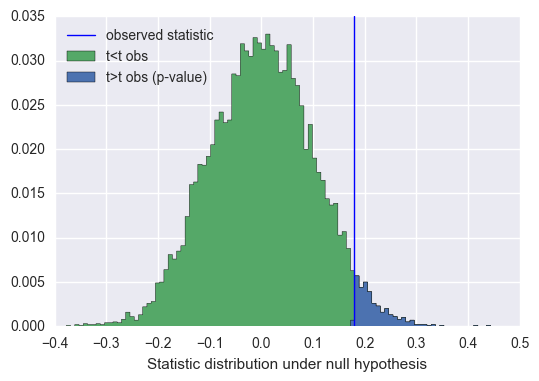

In [25]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#%matplotlib qt

np.random.seed(42)
x = np.random.normal(loc=10, scale=1, size=100)
y = x + np.random.normal(loc=-3, scale=3, size=100) # snr = 1/2

# Permutation: simulate the null hypothesis
nperm = 10000
perms = np.zeros(nperm + 1)

perms[0] = np.corrcoef(x, y)[0, 1]

for i in range(1, nperm):
    perms[i] = np.corrcoef(np.random.permutation(x), y)[0, 1]

# Plot
# Re-weight to obtain distribution
weights = np.ones(perms.shape[0]) / perms.shape[0]
plt.hist([perms[perms >= perms[0]], perms], histtype='stepfilled', 
         bins=100, label=["t>t obs (p-value)", "t<t obs"], 
         weights=[weights[perms >= perms[0]], weights])

plt.xlabel("Statistic distribution under null hypothesis")
plt.axvline(x=perms[0], color='blue', linewidth=1, label="observed statistic")
_ = plt.legend(loc="upper left")

# One-tailed empirical p-value
pval_perm = np.sum(perms >= perms[0]) / perms.shape[0]

# Compare with Pearson's correlation test
_, pval_test = stats.pearsonr(x, y)

print("Permutation two tailed p-value=%.5f. Pearson test p-value=%.5f" % (2*pval_perm, pval_test))

### Exercise

Given the logistic regression presented above and its validation given a 5 folds CV.

1. Compute the p-value associated with the prediction accuracy using a permutation test.

2. Compute the p-value associated with the prediction accuracy using a parametric test.

## Bootstrapping

Bootstrapping is a random sampling with replacement strategy which provides an non-parametric method to assess the variability of performances scores such standard errors or confidence intervals. 

A great advantage of bootstrap is its simplicity. It is a straightforward way to derive estimates of standard errors and confidence intervals for complex estimators of complex parameters of the distribution, such as percentile points, proportions, odds ratio, and correlation coefficients. 

1. Perform $B$ sampling, with replacement, of the dataset.
2. For each sample $i$ fit the model and compute the scores.
3. Assess standard errors and confidence intervals of scores using the scores obtained on the $B$ resampled dataset.

In [3]:
import numpy as np
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import pandas as pd

# Regression dataset
n_features = 5
n_features_info = 2
n_samples = 100
X = np.random.randn(n_samples, n_features)
beta = np.zeros(n_features)
beta[:n_features_info] = 1
Xbeta = np.dot(X, beta)
eps = np.random.randn(n_samples)
y = Xbeta + eps

# Fit model on all data (!! risk of overfit)
model = lm.RidgeCV()
model.fit(X, y)
print("Coefficients on all data:")
print(model.coef_)

# Bootstrap loop
nboot = 100  # !! Should be at least 1000
scores_names = ["r2"]
scores_boot = np.zeros((nboot, len(scores_names)))
coefs_boot = np.zeros((nboot, X.shape[1]))

orig_all = np.arange(X.shape[0])
for boot_i in range(nboot):
    boot_tr = np.random.choice(orig_all, size=len(orig_all), replace=True)
    boot_te = np.setdiff1d(orig_all, boot_tr, assume_unique=False)
    Xtr, ytr = X[boot_tr, :], y[boot_tr]
    Xte, yte = X[boot_te, :], y[boot_te]
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte).ravel()
    scores_boot[boot_i, :] = metrics.r2_score(yte, y_pred)
    coefs_boot[boot_i, :] = model.coef_

# Compute Mean, SE, CI
scores_boot = pd.DataFrame(scores_boot, columns=scores_names)
scores_stat = scores_boot.describe(percentiles=[.99, .95, .5, .1, .05, 0.01])

print("r-squared: Mean=%.2f, SE=%.2f, CI=(%.2f %.2f)" %\
      tuple(scores_stat.ix[["mean", "std", "5%", "95%"], "r2"]))

coefs_boot = pd.DataFrame(coefs_boot)
coefs_stat = coefs_boot.describe(percentiles=[.99, .95, .5, .1, .05, 0.01])
print("Coefficients distribution")
print(coefs_stat)

Coefficients on all data:
[ 0.98143428  0.84248041  0.12029217  0.09319979  0.08717254]
r-squared: Mean=0.57, SE=0.09, CI=(0.39 0.70)
Coefficients distribution
                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.975189    0.831922    0.116888    0.099109    0.085516
std      0.106367    0.096548    0.108676    0.090312    0.091446
min      0.745082    0.593736   -0.112740   -0.126522   -0.141713
1%       0.770362    0.640142   -0.088238   -0.094403   -0.113375
5%       0.787463    0.657473   -0.045593   -0.046201   -0.090458
10%      0.829129    0.706492   -0.037838   -0.020650   -0.044990
50%      0.980603    0.835724    0.133070    0.093240    0.088968
95%      1.127518    0.999604    0.278735    0.251137    0.221887
99%      1.144834    1.036715    0.292784    0.291197    0.287006
max      1.146670    1.077265    0.324374    0.298135    0.289569
